In [ ]:
# default_exp data.core 

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
# hide
from nbdev.showdoc import *

# Data Core

> Using the fastai `Datasets` to make an time series dataset.

For now all is univerable but in the future I would also like to add multiplevariable. 


In [ ]:
# export
from fastseq.data.load import *
from fastseq.core import *
from fastcore.all import *
from fastcore.imports import *
from fastai.basics import *
from fastai.data.transforms import *
from fastai.tabular.core import *

In [ ]:
# hide
# just check previous nb still works. Sometimes import errors
horizon,lookback = 2,5
ints = L(np.arange(7)[None,:],np.arange(7,15)[None,:],np.arange(15,25)[None,:]).map(tensor)
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=2)
test_eq(dl.n, len(dl._ids))
test_eq(dl.n, 7)
test_eq(len(dl),4)    

for o in dl:pass

# Transforms

> Basic function to process time-series data before assembling it in a `DataLoaders`.

In [ ]:
# export
class NormalizeTS(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`. 
        This is for blok seqences to not magnify the `y` part of the data.
        
        `mean` will set a mean instead of the mean of the x value.
        """
        store_attr('verbose, make_ones, eps, mean')
        self.m, self.s = 0, 0
        
    def encodes(self, o):         
        self.m, self.s = torch.mean(o[0],-1,keepdim=True), o[0].std(-1,keepdim=True) +self.eps
        if self.verbose:
            print('encodes',type(o),[a.shape for a in o], self.m,self.s) 
        if self.mean:
            self.m = o[0][self.mean]
        if self.make_ones:
            self.s[self.s < self.eps*10] = 1
            if self.verbose:
                print(o[0])
                print(f"made {self.s < self.eps*10} to ones due to setting `make_ones`")
                print(f"m:{self.m}\n s:{self.s}")
        return Tuple([(o[i]-self.m)/self.s for i in range(len(o))])
    
    def decodes(self, o): 
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',type(o),[a.shape for a in o], 'shape m/s',self.m.shape)
        return Tuple([(o[i]*self.s)+self.m for i in range(len(o))])
        
        
        

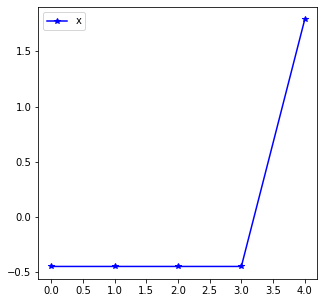

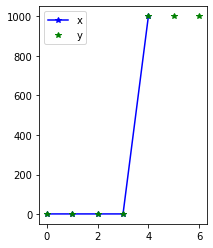

In [ ]:
# hide
# testing the flatline with a bumb (block sequence)
from fastseq.data.load import *
horizon,lookback = 2,5
a = np.ones(7)[None,:]
a[:,-3:] = 1000
ints = L(a).map(tensor)

dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=16, after_batch=NormalizeTS(), min_seq_len=6, num_workers = 1)
for o in dl:
    test_close(o[0].mean(),0)
    test_close(o[0].std(),1,.5)
    test_eq(type(o),Tuple)
    o[0].show()
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    test_eq(type(o_new),Tuple)
    
test_eq(type(dl.one_batch()),Tuple)

dl.show_batch()

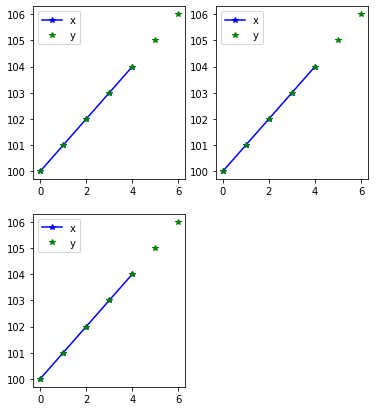

In [ ]:
# hide
from fastseq.data.load import *
horizon,lookback = 2,5
ints = L( np.arange(7)[None,:]*1+100, np.arange(8)[None,:]*100+1,).map(tensor)
dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=16, after_batch=NormalizeTS(), min_seq_len=6, num_workers = 1)
for o in dl:
    test_close(o[0].mean(),0)
    test_close(o[0].std(),1,.5)
    test_eq(type(o),Tuple)
    
    o_new = dl.after_batch[0].decode(o)
    test_eq(o_new[0].mean()!=0, True)
    test_eq(o_new[0].std()!=1, True)
    test_eq(type(o_new),Tuple)
    
test_eq(type(dl.one_batch()),Tuple)

dl.show_batch()

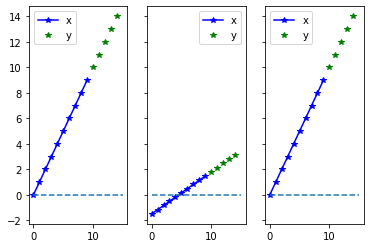

In [ ]:
norm = NormalizeTS()
o = (TSTensorSeq(torch.arange(10.)),TSTensorSeqy( torch.arange(10,15),x_len=10))
o_en = norm(o)
test_eq(o_en[0].mean(), 0)
test_eq(o_en[1].mean()==0, False)
dec_o = norm.decode(o_en)
test_eq(dec_o[0],o[0])

f,axs = plt.subplots(1,3, sharey=True)
ax = o[0].show(axs[0])
o[1].show(ax)
ax.plot([0,15],[0,0],'--')
ax = o_en[0].show(axs[1])
o_en[1].show(ax)
ax.plot([0,15],[0,0],'--')
ax = dec_o[0].show(axs[2])
dec_o[1].show(ax)
ax.plot([0,15],[0,0],'--')


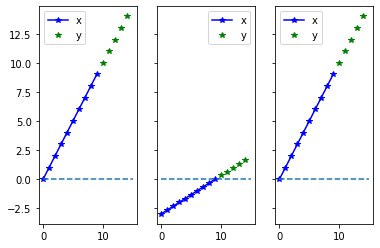

In [ ]:
norm = NormalizeTS(mean=9)
o = (TSTensorSeq(torch.arange(10.)),TSTensorSeqy( torch.arange(10,15),x_len=10))
o_en = norm(o)
test_eq(o_en[0][-1], 0)
test_eq(o_en[1][-1]==0, False)
dec_o = norm.decode(o_en)
test_eq(dec_o[0],o[0])

f,axs = plt.subplots(1,3, sharey=True)
ax = o[0].show(axs[0])
o[1].show(ax)
ax.plot([0,15],[0,0],'--')
ax = o_en[0].show(axs[1])
o_en[1].show(ax)
ax.plot([0,15],[0,0],'--')
ax = dec_o[0].show(axs[2])
dec_o[1].show(ax)
ax.plot([0,15],[0,0],'--')


In [ ]:
# hide
if torch.cuda.is_available():
    from fastseq.data.load import *
    horizon,lookback = 2,5
    ints = L(tensor(o) for o in  [ np.arange(7)[None,:]*1+100, np.arange(8)[None,:]*100+1,])

    dl = TSDataLoader(ints, horizon = horizon, lookback = lookback, bs=16, after_batch=NormalizeTS(), num_workers = 1, device=torch.device('cuda'))    
    for o in dl:
#         test if data on cuda will will stay there
        test_eq(o[0].is_cuda, True)
        dec_o = dl.after_batch[0].decode(o)
        test_eq(dec_o[0].is_cuda, True)  
        
#         test if o is already moved to cpu
        dec_o = dl.after_batch[0].decode(to_cpu(o))
        test_eq(dec_o[0].is_cuda, False)  
        
        
    dl.show_batch()

In [ ]:
# hide
# test if o is cuda but m,s are on cpu
if torch.cuda.is_available():
    norm = NormalizeTS()
    o = (TSTensorSeq(torch.arange(10.)),TSTensorSeqy( torch.arange(10.,15),x_len=10))
    o_en = norm(o)
    test_eq(o_en[0].mean(), 0)
    test_eq(o_en[1].mean()==0, False)
    dec_o = norm.decode(to_device(o_en))
    test_eq(dec_o[0],to_device(o[0]))

    # test if o_enc[0] and o_enc[1] are on different devices
    o_enc = Tuple([to_device(o_en[0],'cpu'),to_device(o_en[1],'cuda'),])
    dec_o = norm.decode(o_enc)
    test_eq(dec_o[0],o[0])

    o_enc = Tuple([to_device(o_en[0],'cuda'),to_device(o_en[1],'cpu'),])
    dec_o = norm.decode(o_enc)
    test_eq(dec_o[0],to_device(o[0]))
    
    norm.m, norm.s = to_device(norm.m), to_device(norm.s)
    o_enc = Tuple([to_device(o_en[0],'cuda'),to_device(o_en[1],'cpu'),])
    dec_o = norm.decode(o_enc)
    test_eq(dec_o[0],to_device(o[0]))

# TSDataLoaders

## Utils

In [ ]:
# export 
def concat_ts_list(train, val):
    items=L()
    assert len(train) == len(val)
    for t, v in zip(train, val):
        items.append(np.concatenate([t,v],1))
    return items

In [ ]:
a = [np.random.randn(3,10)]*50
b = [np.random.randn(3,5)]*50
r = concat_ts_list(a,b)
test_eq(r[0].shape,(3,15))
test_eq(r[0], np.concatenate([a[0],b[0]],1))

In [ ]:
# export 
def make_test(items:L(), horizon:int, lookback:int, keep_lookback:bool = False):
    """Splits the every ts in `items` based on `horizon + lookback`*, where the last part will go into `val` and the first in `train`.
    
    *if `keep_lookback`:
        it will only remove `horizon` from `train` otherwise also lookback.
    """
    train, val = L(), L()
    for ts in items:        
        val.append(ts[:, -(horizon+lookback):])
        if keep_lookback:
            train.append(ts[:, :-(horizon)])
        else:
            train.append(ts[:, :-(horizon+lookback)])
            
    return train, val

def make_test_pct(items:L(), pct:float):
    """Splits the every ts in `items` based on `pct`(percentage) of the length of the timeserie, where the last part will go into `val` and the first in `train`.
    
    """
    train, val = L(), L()
    for ts in items:        
        split_idx = int((1-pct)*ts.shape[1])   
        train.append(ts[:,:split_idx])
        val.append(ts[:,split_idx:])
            
    return train, val

In [ ]:
a = [np.random.randn(3,15)]*50
train, val = make_test(a,5,5)
test_eq(train[0],a[0][:,:-10])
test_eq(val[0],a[0][:,-10:])

train, val = make_test(a,5,5,True)
test_eq(train[0],a[0][:,:-5])
test_eq(val[0],a[0][:,-10:])

## Dataloaders

In [ ]:
d = {}

In [ ]:
d.pop('k',1)

1

In [ ]:
#export
class TSDataLoaders(DataLoaders):
    @classmethod
    @delegates(TSDataLoader.__init__)
    def from_folder(cls, data_path:Path, valid_pct=.5, seed=None, horizon=None, lookback=None, step=1,
                   nrows=None, skiprows=None, incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create from M-compition style in `path` with `train`,`test` csv-files. 
        
        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        train, test = get_ts_files(data_path, nrows=nrows, skiprows=skiprows)
        items = concat_ts_list(train, test).map(tensor)
        horizon = ifnone(horizon, len(test[0]))
        lookback = ifnone(lookback, horizon * 3)
        return cls.from_items(items, horizon, lookback = lookback,  step = step, incl_test=incl_test, path=path, device=device, norm= norm,**kwargs)


    @classmethod
    @delegates(TSDataLoader.__init__)
    def from_items(cls, items:L, horizon:int, valid_pct=1.5, seed=None, lookback=None, step=1,
                   incl_test = True, path:Path='.', device=None, norm=True, **kwargs):
        """Create an list of time series. 

        The `DataLoader` for the test set will be save as an attribute under `test`
        """
        if len(items[0].shape)==1:
            items = [i[None,:] for i in items]
        print(items[0].shape)
        lookback = ifnone(lookback, horizon * 4)
        if incl_test:
            items, test = make_test(items, horizon, lookback, keep_lookback = True)
        train, valid = make_test(items, horizon + int(valid_pct*horizon), lookback , keep_lookback = True)
        if norm:
            make_ones = kwargs.pop('make_ones',True)                
            kwargs.update({'after_batch':L(kwargs.get('after_batch',None))+L(NormalizeTS(make_ones=make_ones))})
        db = DataLoaders(*[TSDataLoader(items, horizon=horizon, lookback=lookback, step=step, **kwargs) 
                           for items in [train,valid]], path=path, device=device)
        if device is None:
            db.cuda()
        if incl_test:
            db.test = TSDataLoader(test, horizon=horizon, lookback=lookback, step=step, name='test')
            print(f"Train:{db.train.n}; Valid: {db.valid.n}; Test {db.test.n}")
        else:
            print(f"Train:{db.train.n}; Valid: {db.valid.n}")
#         TODO add with test_dl, currently give buges 
        return db 

In [ ]:
# hide
horizon, lookback = 7,10
items = L(np.arange(-5,100)[None,:],np.arange(500,550)[None,:],np.arange(-110,-56)[None,:]).map(tensor)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=5)
test_eq(data.valid.dataset[0].shape[-1]>lookback+horizon, True)

torch.Size([1, 105])


NameError: name 'make_test' is not defined

In [ ]:
# hide
horizon,lookback = 2,5
items = L(np.arange(20),np.arange(25,48),np.arange(8,27)).map(tensor)
dbunch = TSDataLoaders.from_items(items, horizon=horizon, lookback = lookback, incl_test=False)
test_eq(hasattr(dbunch,'test'),False)

torch.Size([1, 20])
Train:29; Valid: 12


In [ ]:
# hide
path = untar_data(URLs.m4_daily)
if torch.cuda.is_available():
    dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=10)
    for o in dbunch.train.one_batch():
        test_eq(o.is_cuda, True)
        break
    for o in dbunch.valid:
        test_eq(o[0].is_cuda, True)
        break

torch.Size([1, 1020])
Train:1255; Valid: 50; Test 10


In [ ]:
# hide
dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=10, device = 'cpu')
for o in dbunch.train:
    test_eq(o[0].is_cuda, False)
    break
for o in dbunch.valid:
    test_eq(o[0].is_cuda, False)
    break
    

torch.Size([1, 1020])
Train:1255; Valid: 50; Test 10


In [ ]:
# hide
test_eq(dbunch.train.n,1255)
test_eq(dbunch.valid.n,50)
test_eq(dbunch.test.n,10)

In [ ]:
# hide
dl = dbunch.new(shuffle=True)

In [ ]:
dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=10, device = 'cpu', after_batch=noop)
for o in dbunch[0]:
    test_close(o[0].mean(),0)
    test_close(o[0].std(),1,eps=.1)    

Train:1255; Valid: 50; Test 10


In [ ]:
show_doc(TSDataLoaders.from_items, name='TSDataLoaders.from_items')

<h4 id="TSDataLoaders.from_items" class="doc_header"><code>TSDataLoaders.from_items</code><a href="__main__.py#L18" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_items</code>(**`items`**:`L`, **`horizon`**:`int`, **`valid_pct`**=*`1.5`*, **`seed`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create an list of time series. 

The `DataLoader` for the test set will be save as an attribute under `test`

In [ ]:
show_doc(TSDataLoaders.from_folder, name='TSDataLoaders.from_folder')

<h4 id="TSDataLoaders.from_folder" class="doc_header"><code>TSDataLoaders.from_folder</code><a href="__main__.py#L3" class="source_link" style="float:right">[source]</a></h4>

> <code>TSDataLoaders.from_folder</code>(**`data_path`**:`Path`, **`valid_pct`**=*`0.5`*, **`seed`**=*`None`*, **`horizon`**=*`None`*, **`lookback`**=*`None`*, **`step`**=*`1`*, **`nrows`**=*`None`*, **`skiprows`**=*`None`*, **`incl_test`**=*`True`*, **`path`**:`Path`=*`'.'`*, **`device`**=*`None`*, **`bs`**=*`64`*, **`shuffle`**=*`False`*, **`num_workers`**=*`None`*, **`verbose`**=*`False`*, **`do_setup`**=*`True`*, **`pin_memory`**=*`False`*, **`timeout`**=*`0`*, **`batch_size`**=*`None`*, **`drop_last`**=*`False`*, **`indexed`**=*`None`*, **`n`**=*`None`*, **`wif`**=*`None`*, **`before_iter`**=*`None`*, **`after_item`**=*`None`*, **`before_batch`**=*`None`*, **`after_batch`**=*`None`*, **`after_iter`**=*`None`*, **`create_batches`**=*`None`*, **`create_item`**=*`None`*, **`create_batch`**=*`None`*, **`retain`**=*`None`*, **`get_idxs`**=*`None`*, **`sample`**=*`None`*, **`shuffle_fn`**=*`None`*, **`do_batch`**=*`None`*)

Create from M-compition style in `path` with `train`,`test` csv-files. 

The `DataLoader` for the test set will be save as an attribute under `test`

Train:9408; Valid: 500; Test 100


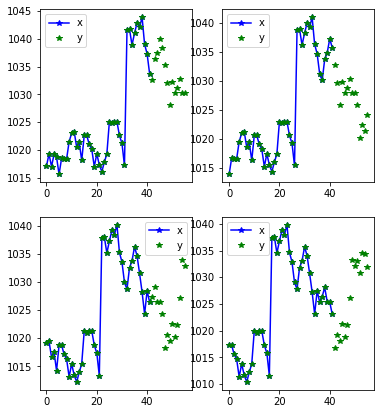

In [ ]:
dbunch = TSDataLoaders.from_folder(path, horizon = 14, step=5, bs=64, nrows=100)
dbunch.train.show_batch(max_n=4)

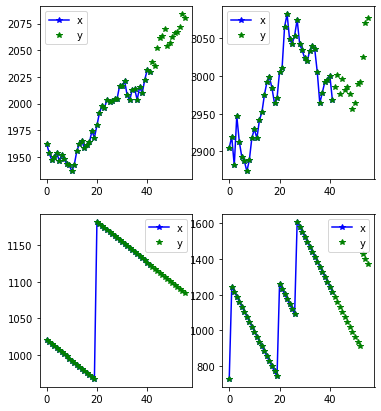

In [ ]:
dbunch.test.show_batch(max_n=4)

In [ ]:
# hide
from nbdev.export import *

notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
